<a href="https://colab.research.google.com/github/gschink/DSBA_6010_Gschink/blob/main/Meme_Stock_Positive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is all in working order. It is built from https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb. Additional assets and views need to be supplied.  

In [2]:
!pip install PyPortfolioOpt

     |████████████████████████████████| 61 kB 3.4 MB/s 
     |████████████████████████████████| 2.8 MB 11.5 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [3]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 7.7 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import BlackLittermanModel, black_litterman, risk_models, plotting, EfficientFrontier, objective_functions
import yfinance as yf

In [5]:
#need to pick additional assets

tickers = ["TSLA", "TWTR", "AMC", "GME"]

ohlc = yf.download(tickers)
prices = ohlc["Adj Close"]
prices.tail()

[*********************100%***********************]  4 of 4 completed


,AMC,GME,TSLA,TWTR
Date,,,,
2022-04-18,17.48,141.460007,1004.289978,48.450001
2022-04-19,18.68,152.470001,1028.150024,46.160000
2022-04-20,17.34,148.850006,977.200012,46.720001
2022-04-21,16.85,141.559998,1008.780029,47.080002
2022-04-22,16.52,138.220001,1005.049988,48.930000


In [6]:
market_prices = yf.download("SPY")["Adj Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Date
1993-01-29    25.547987
1993-02-01    25.729677
1993-02-02    25.784185
1993-02-03    26.056767
1993-02-04    26.165800
Name: Adj Close, dtype: float64

In [7]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'AMC': 8480211456,
 'GME': 10551604224,
 'TSLA': 1038729216000,
 'TWTR': 37361872896}

In [8]:
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.673455896113898

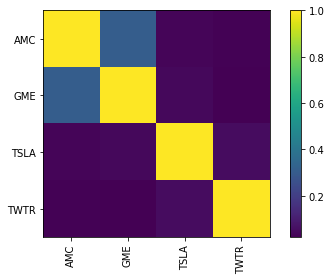

In [9]:
plotting.plot_covariance(S, plot_correlation=True);

In [10]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AMC     0.077122
GME     0.082521
TSLA    0.816746
TWTR    0.087380
dtype: float64

In [11]:
viewdict = {
  'AMC': .5,
  'GME': .5,
  'TSLA': .5,
  'TWTR': .5
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

In [12]:
confidences = [
              1,
              1,
              1,
              1,
]

In [13]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

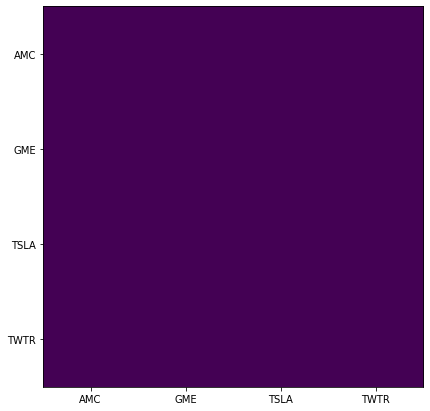

In [14]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [15]:
np.diag(bl.omega)

array([0., 0., 0., 0.])

In [17]:
intervals = [
    (-.25, 0.25),
    (-.25, 0.25),
    (-.25, 0.25),
    (-.25, 0.25)
]

In [18]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.0625, 0.0625, 0.0625, 0.0625]


In [19]:
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [20]:
ret_bl = bl.bl_returns()
ret_bl

AMC     0.228668
GME     0.219672
TSLA    0.746744
TWTR    0.147746
dtype: float64

In [21]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AMC,0.077122,0.228668,0.5
GME,0.082521,0.219672,0.5
TSLA,0.816746,0.746744,0.5
TWTR,0.087380,0.147746,0.5


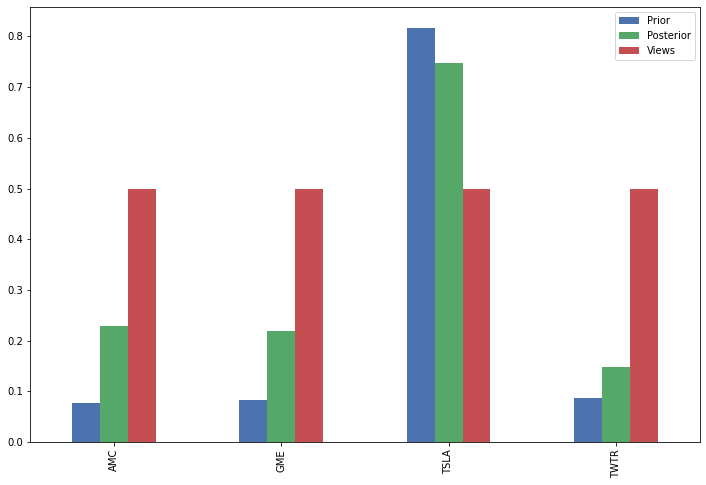

In [22]:
rets_df.plot.bar(figsize=(12,8));

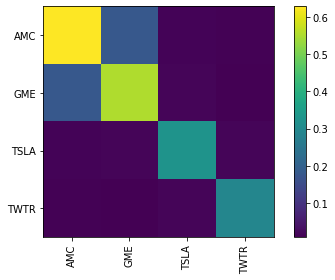

In [23]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

In [24]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


OrderedDict([('AMC', 0.12914),
             ('GME', 0.12768),
             ('TSLA', 0.63768),
             ('TWTR', 0.1055)])

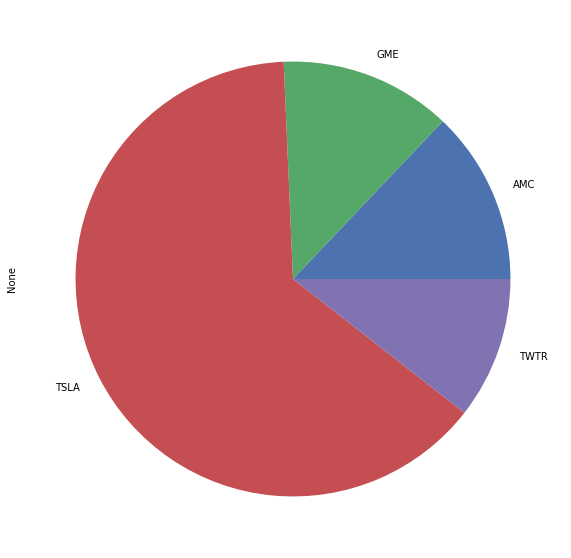

In [25]:
pd.Series(weights).plot.pie(figsize=(10,10));